### Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools

df = pd.read_csv("zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [2]:
# Import HF - HELP RAFA
# from dsc file
import helper_functions as hf

In [3]:
# from a .py file
from importlib import reload
from helper_functions import hf_ml as hfm
from helper_functions import hf_arima as hfa

In [4]:
from helper_functions import hf_arima as hfa

In [5]:
reload(hf)

<module 'helper_functions' from '/Users/bryanjamieson/flatiron/dsc-mod-4-project-online-ds-ft-090919/helper_functions/__init__.py'>

In [6]:
hfa.summ(3, 5)

8

In [7]:
#region name = zipcode
df_GA = df.loc[df["State"] == 'GA']
df_GA.head(15)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
28,71067,30349,Riverdale,GA,Atlanta,Clayton,29,90900.0,91100.0,91200.0,...,118700,119900,121400,122900,123800,124600,126200,127300,127700,128100
42,70829,30044,Lawrenceville,GA,Atlanta,Gwinnett,43,111400.0,111800.0,112200.0,...,169500,170900,172800,174700,176400,178500,180100,181000,182200,183400
51,70828,30043,Lawrenceville,GA,Atlanta,Gwinnett,52,135200.0,135500.0,135800.0,...,213600,216000,218400,220300,221900,223700,225500,226700,227800,228800
65,70874,30096,Duluth,GA,Atlanta,Gwinnett,66,119700.0,120000.0,120300.0,...,205900,207600,209400,211200,212700,214600,216500,218100,219800,221100
78,70810,30024,Suwanee,GA,Atlanta,Gwinnett,79,179600.0,181000.0,182400.0,...,330100,331700,333400,334800,336100,338600,341300,343200,344900,346300
101,71005,30281,Stockbridge,GA,Atlanta,Henry,102,94300.0,95700.0,97100.0,...,145100,146400,147400,148200,149300,149900,149400,149500,150800,151700
176,70825,30040,Cumming,GA,Atlanta,Forsyth,177,145200.0,145400.0,145900.0,...,277200,278300,279900,281600,283400,285900,288100,290000,292100,293200
177,70953,30188,Woodstock,GA,Atlanta,Cherokee,178,119200.0,119500.0,119800.0,...,213900,215100,216400,218200,220700,223200,225200,227100,229200,230800
213,70859,30080,Smyrna,GA,Atlanta,Cobb,214,133000.0,133100.0,133100.0,...,282400,284400,286900,290000,293700,297100,299400,302400,307100,311000
221,70842,30062,Marietta,GA,Atlanta,Cobb,222,150000.0,150500.0,150900.0,...,309200,310600,313300,316500,319100,321400,323100,324700,327000,328700


In [8]:
df_GA['CountyName'].unique()

array(['Clayton', 'Gwinnett', 'Henry', 'Forsyth', 'Cherokee', 'Cobb',
       'Fulton', 'Douglas', 'Chatham', 'Muscogee', 'Houston', 'Coweta',
       'Dekalb', 'Columbia', 'Clarke', 'Newton', 'Whitfield', 'Baldwin',
       'Hall', 'Catoosa', 'Bartow', 'Barrow', 'Floyd', 'Bulloch', 'Bibb',
       'Gordon', 'Fayette', 'Carroll', 'Lowndes', 'Murray', 'Walker',
       'Dougherty', 'Troup', 'Rockdale', 'Glynn', 'Dawson', 'Laurens',
       'Bryan', 'Tift', 'Lumpkin', 'Spalding', 'Pickens', 'Upson',
       'Walton', 'Lee', 'White', 'Thomas', 'Putnam', 'Stephens', 'Union',
       'Polk', 'Jackson', 'Butts', 'Gilmer', 'Effingham', 'Colquitt',
       'Camden', 'Peach', 'Ware', 'Hart', 'Greene', 'Fannin', 'Monroe',
       'Coffee', 'Habersham', 'Jones', 'Haralson', 'Morgan', 'Lamar',
       'Rabun', 'Liberty', 'Oconee', 'Madison', 'Harris', 'Wayne', 'Pike',
       'Banks', 'Wilcox', 'Calhoun'], dtype=object)

In [9]:
GA_Counties = ["Fulton", "Dekalb", "Cobb"]

In [10]:
df_GA_2 = df_GA.loc[(df_GA["CountyName"] == "Fulton")|
          (df_GA["CountyName"] == "Dekalb")|
          (df_GA["CountyName"] == "Cobb")]

In [11]:
#buckhead,roswell,atlanta
df_GA_2["City"].unique()

array(['Smyrna', 'Marietta', 'Atlanta', 'Johns Creek', 'Powder Springs',
       'Milton', 'Lithonia', 'Acworth', 'Roswell', 'Kennesaw',
       'Brookhaven', 'Candler-Mcafee', 'Panthersville', 'Vinings',
       'Sandy Springs', 'Mableton', 'Tucker', 'Dunwoody', 'Fairburn',
       'Conley', 'North Decatur', 'Stone Mountain', 'North Druid Hills',
       'Chamblee', 'Decatur', 'Alpharetta', 'Austell', 'Union City',
       'Palmetto', 'Avondale Estates', 'Scottdale'], dtype=object)

In [12]:
#df_GA_2[df.loc["Fulton"]]
df_GA_2.head()
#melt data to get it vertical

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
213,70859,30080,Smyrna,GA,Atlanta,Cobb,214,133000.0,133100.0,133100.0,...,282400,284400,286900,290000,293700,297100,299400,302400,307100,311000
221,70842,30062,Marietta,GA,Atlanta,Cobb,222,150000.0,150500.0,150900.0,...,309200,310600,313300,316500,319100,321400,323100,324700,327000,328700
227,71050,30331,Atlanta,GA,Atlanta,Fulton,228,97100.0,97700.0,98400.0,...,130300,131300,132700,134000,135100,137000,139400,140800,141500,141600
254,70808,30022,Johns Creek,GA,Atlanta,Fulton,255,206900.0,207300.0,207800.0,...,393700,393900,395400,396600,397600,399600,402400,405100,407800,409000
296,70904,30127,Powder Springs,GA,Atlanta,Cobb,297,119300.0,119300.0,119300.0,...,182600,183600,185300,187300,189000,190600,192100,194000,197100,199500


# Step 2: Data Preprocessing

In [13]:
# Get data in propper formatting.
# dates, values
# region name as name, dates as index column

In [14]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [15]:
dates = df_GA_2.columns[7:]

# Format data from horizontal to vertical
* Grab the date values from each zip code and make it a column in our new dataframe

In [16]:
new_df  = pd.DataFrame()
new_df['dates'] = dates

for index in range(df_GA_2.shape[0]):
    row = df_GA_2.iloc[index]
    region_name = row['RegionName']
    date_values = row[dates].values
    new_df[region_name] = date_values
new_df.head()

,dates,30080,30062,30331,30022,30127,30004,30066,30058,30101,...,30106,30009,30317,30360,30326,30268,30288,30002,30363,30079
0,1996-04,133000,150000,97100,206900,119300,184800,124700,84600,133700,...,91300,145900,51800,141000,238100,86400,NaN,131300,131400,NaN
1,1996-05,133100,150500,97700,207300,119300,185500,124900,85200,133700,...,91400,146400,52500,141600,240100,86800,NaN,131500,131700,NaN
2,1996-06,133100,150900,98400,207800,119300,186100,125100,85800,133700,...,91500,146900,53200,142200,242100,87100,NaN,131700,132000,NaN
3,1996-07,133200,151300,99100,208300,119400,186700,125400,86400,133700,...,91600,147400,53900,142900,244000,87500,NaN,131900,132300,NaN
4,1996-08,133200,151600,100000,208900,119400,187300,125700,87000,133700,...,91800,147900,54500,143600,245800,87900,NaN,132200,132800,NaN


In [17]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 60 columns):
dates    265 non-null object
30080    265 non-null object
30062    265 non-null object
30331    265 non-null object
30022    265 non-null object
30127    265 non-null object
30004    265 non-null object
30066    265 non-null object
30058    265 non-null object
30101    265 non-null object
30067    265 non-null object
30075    265 non-null object
30144    265 non-null object
30319    265 non-null object
30032    58 non-null object
30064    265 non-null object
30309    265 non-null object
30076    265 non-null object
30034    265 non-null object
30324    265 non-null object
30339    265 non-null object
30350    265 non-null object
30328    265 non-null object
30126    265 non-null object
30038    265 non-null object
30316    265 non-null object
30084    265 non-null object
30305    265 non-null object
30152    265 non-null object
30102    265 non-null object
30338    265 non-null obje

# Change 'dates' column to datetime format

In [18]:
new_df['dates'] = pd.to_datetime(new_df['dates'])
new_df.head()

,dates,30080,30062,30331,30022,30127,30004,30066,30058,30101,...,30106,30009,30317,30360,30326,30268,30288,30002,30363,30079
0,1996-04-01,133000,150000,97100,206900,119300,184800,124700,84600,133700,...,91300,145900,51800,141000,238100,86400,NaN,131300,131400,NaN
1,1996-05-01,133100,150500,97700,207300,119300,185500,124900,85200,133700,...,91400,146400,52500,141600,240100,86800,NaN,131500,131700,NaN
2,1996-06-01,133100,150900,98400,207800,119300,186100,125100,85800,133700,...,91500,146900,53200,142200,242100,87100,NaN,131700,132000,NaN
3,1996-07-01,133200,151300,99100,208300,119400,186700,125400,86400,133700,...,91600,147400,53900,142900,244000,87500,NaN,131900,132300,NaN
4,1996-08-01,133200,151600,100000,208900,119400,187300,125700,87000,133700,...,91800,147900,54500,143600,245800,87900,NaN,132200,132800,NaN


# Set 'dates' column as our index

In [19]:
new_df.set_index('dates', inplace=True)

In [20]:
# Create New DF containing summary time series for region and each of the 3 counties.

In [21]:
Fulton_zipcodes = list(df_GA_2[df_GA_2.CountyName=='Fulton']['RegionName'])
Dekalb_zipcodes = list(df_GA_2[df_GA_2.CountyName=='Dekalb']['RegionName'])
Cobb_zipcodes = list(df_GA_2[df_GA_2.CountyName=='Cobb']['RegionName'])

In [22]:
summary_df = pd.DataFrame()
summary_df['Region'] = new_df.mean(axis=1)
summary_df['Fulton'] = new_df[Fulton_zipcodes].mean(axis=1)
summary_df['Dekalb'] = new_df[Dekalb_zipcodes].mean(axis=1)
summary_df['Cobb'] = new_df[Cobb_zipcodes].mean(axis=1)

# Step 3: EDA and Visualization

In [23]:
import matplotlib
font = {
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [24]:
plt.gcf().autofmt_xdate()

<Figure size 432x288 with 0 Axes>

In [25]:
new_df.head()

,30080,30062,30331,30022,30127,30004,30066,30058,30101,30067,...,30106,30009,30317,30360,30326,30268,30288,30002,30363,30079
dates,,,,,,,,,,,,,,,,,,,,,
1996-04-01,133000,150000,97100,206900,119300,184800,124700,84600,133700,175300,...,91300,145900,51800,141000,238100,86400,NaN,131300,131400,NaN
1996-05-01,133100,150500,97700,207300,119300,185500,124900,85200,133700,175600,...,91400,146400,52500,141600,240100,86800,NaN,131500,131700,NaN
1996-06-01,133100,150900,98400,207800,119300,186100,125100,85800,133700,175900,...,91500,146900,53200,142200,242100,87100,NaN,131700,132000,NaN
1996-07-01,133200,151300,99100,208300,119400,186700,125400,86400,133700,176100,...,91600,147400,53900,142900,244000,87500,NaN,131900,132300,NaN
1996-08-01,133200,151600,100000,208900,119400,187300,125700,87000,133700,176300,...,91800,147900,54500,143600,245800,87900,NaN,132200,132800,NaN


In [26]:
new_df.head()

,30080,30062,30331,30022,30127,30004,30066,30058,30101,30067,...,30106,30009,30317,30360,30326,30268,30288,30002,30363,30079
dates,,,,,,,,,,,,,,,,,,,,,
1996-04-01,133000,150000,97100,206900,119300,184800,124700,84600,133700,175300,...,91300,145900,51800,141000,238100,86400,NaN,131300,131400,NaN
1996-05-01,133100,150500,97700,207300,119300,185500,124900,85200,133700,175600,...,91400,146400,52500,141600,240100,86800,NaN,131500,131700,NaN
1996-06-01,133100,150900,98400,207800,119300,186100,125100,85800,133700,175900,...,91500,146900,53200,142200,242100,87100,NaN,131700,132000,NaN
1996-07-01,133200,151300,99100,208300,119400,186700,125400,86400,133700,176100,...,91600,147400,53900,142900,244000,87500,NaN,131900,132300,NaN
1996-08-01,133200,151600,100000,208900,119400,187300,125700,87000,133700,176300,...,91800,147900,54500,143600,245800,87900,NaN,132200,132800,NaN


Text(0, 0.5, '$')

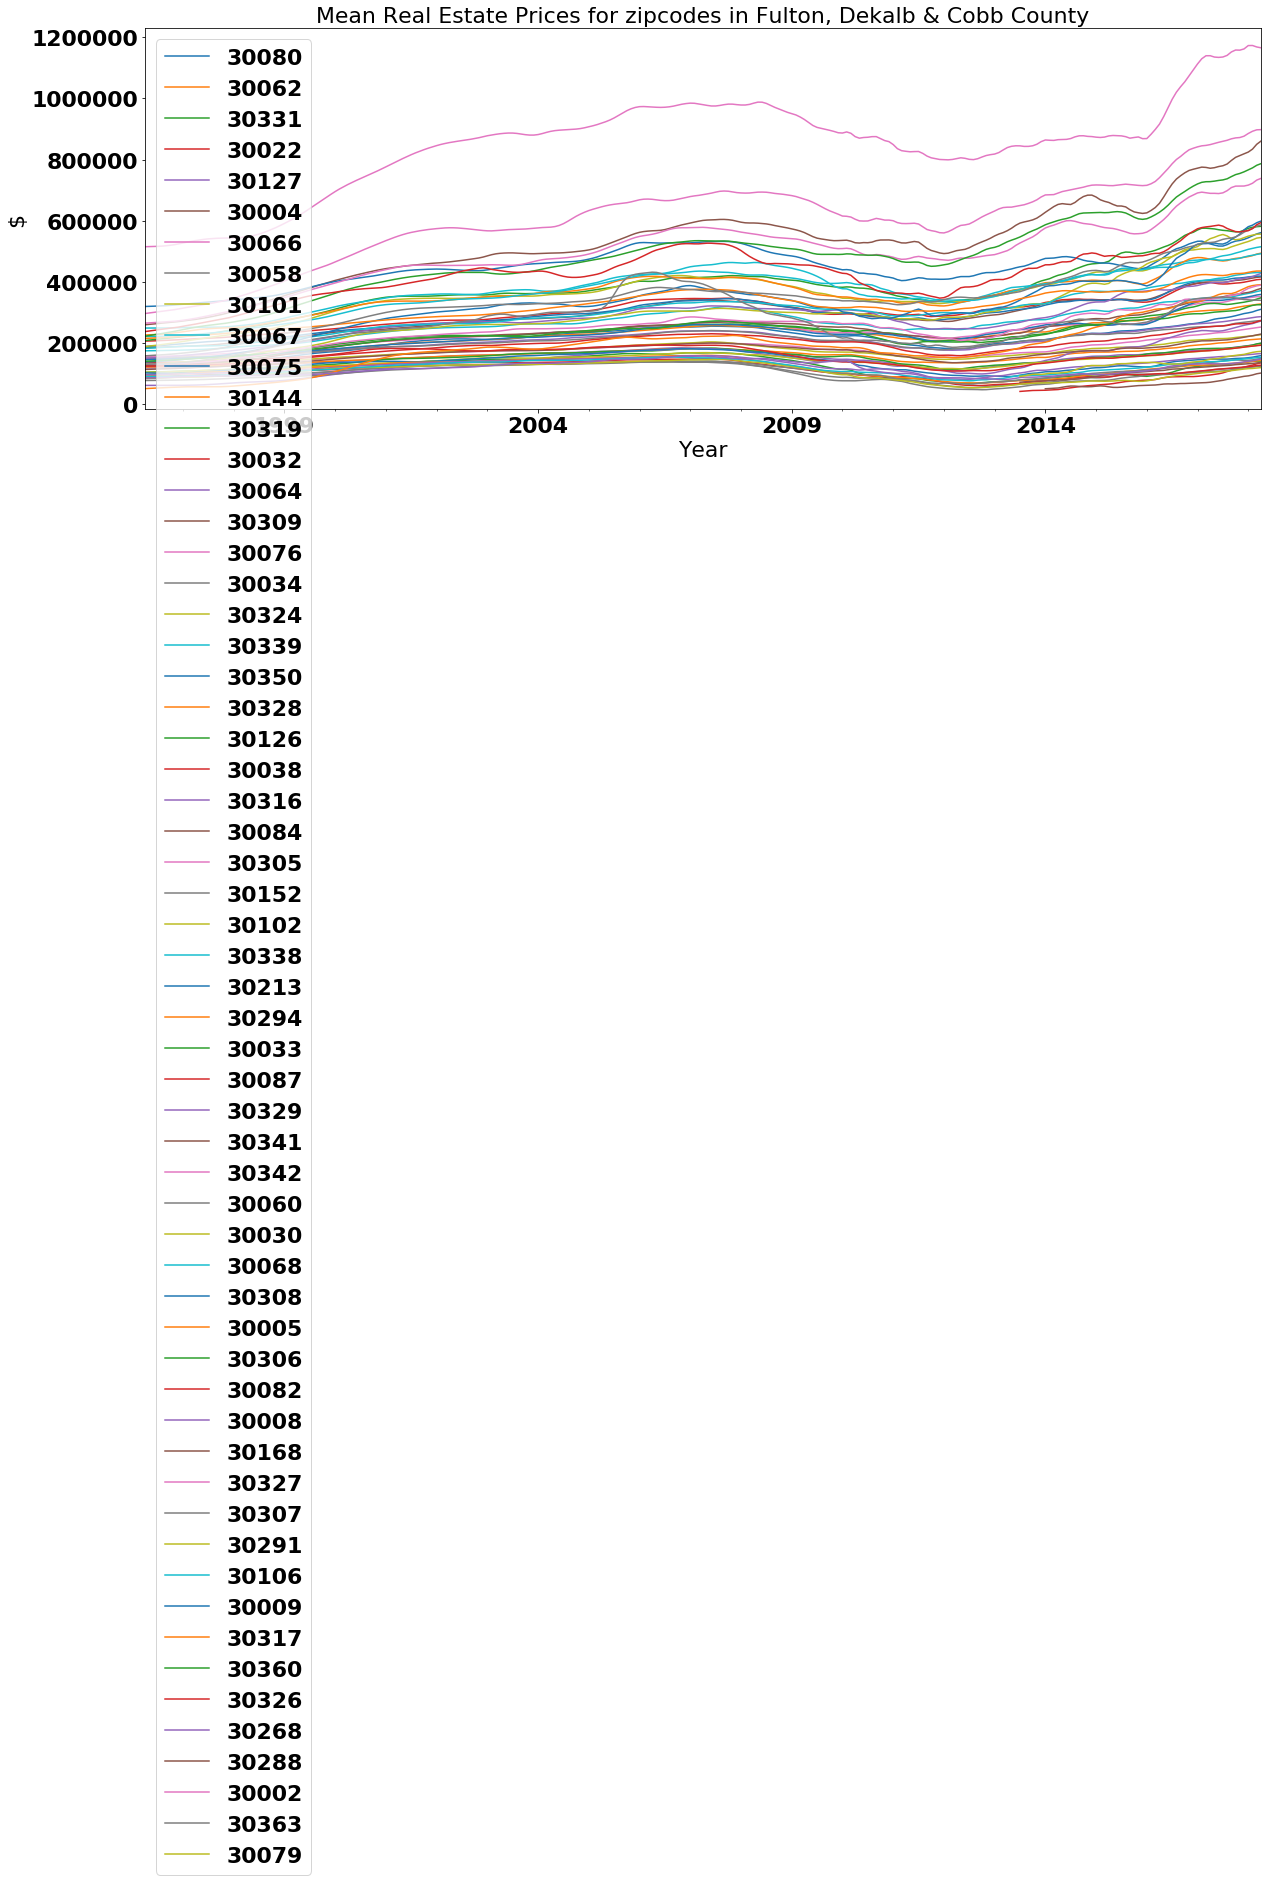

In [27]:
new_df.plot(figsize=(20,7),legend=True)
plt.title("Mean Real Estate Prices for zipcodes in Fulton, Dekalb & Cobb County",{'size':22});
plt.xlabel("Year",{'size':22})
plt.ylabel("$",{'size':22})

In [28]:
# EDA TO FIND TRENDS IN DATA
# find trends in data using detrending
# use acf and pacf to find correlation values 
# do a gridsearch on SARIMAX modeling (p, d, q) (SP, SD, SQ, S)

Text(0, 0.5, '$')

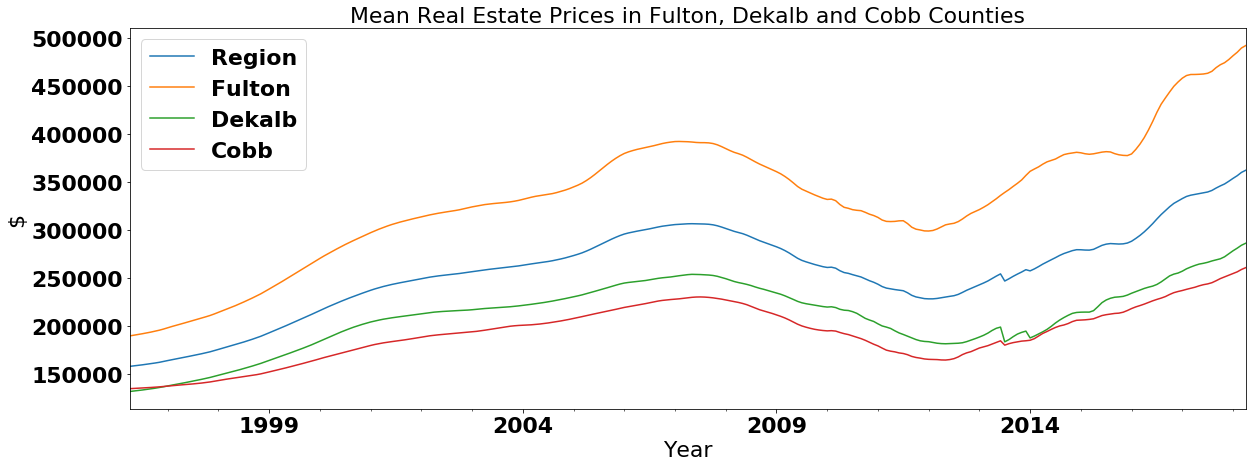

In [29]:
summary_df.plot(figsize=(20,7),legend=True)
plt.title("Mean Real Estate Prices in Fulton, Dekalb and Cobb Counties",{'size':22});
plt.xlabel("Year",{'size':22})
plt.ylabel("$",{'size':22})

# change index

In [30]:
# Seasonal Decomposition

import numpy as np

In [31]:
decomposition = seasonal_decompose((summary_df))
# added freq=5 while trouble shooting
# watch rafs time series vid
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Go back and understand this because time series decompose isnt necces - 

TypeError: Index(...) must be called with a collection of some kind, 'seasonal' was passed

In [ ]:
trend.Region.plot(figsize=(20,4),legend=True,title='Trend')
plt.title("Trend",{'size':22});
plt.xlabel("Year",{'size':22})
plt.show()

seasonal.Region.plot(figsize=(20,4),legend=True,title='Seasonality')
plt.title("Seasonality",{'size':22});
plt.xlabel("Year",{'size':22})
plt.show()

residual.Region.plot(figsize=(20,4),legend=True,title='Residual')
plt.title("Residual",{'size':22});
plt.xlabel("Year",{'size':22})
plt.legend(loc='lower left')
plt.show()

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

In [ ]:
split_date = '2017-08'
training, validation = summary_df[:split_date].Region, summary_df[split_date:].Region
ts = summary_df.Region

In [ ]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(summary_df.values, p_values, d_values, q_values)

# Step 6: Interpreting Results